In [939]:
from utils import u_time as ut
from eod import read_eod as re
import salem
import datetime as dt
import numpy as np
from scipy.ndimage.measurements import label 
import pyproj
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from wavelet import util
import cleo
from skimage.feature import match_template
from skimage.feature import peak_local_max
import pickle as pkl
from skimage.measure import compare_ssim
from scipy.stats.stats import pearsonr
from scipy import ndimage
import pywt
pylab.rcParams['figure.figsize'] = 20., 12.
%matplotlib inline

In [1060]:
trmm_folder='/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA'
msg_folder='/users/global/cornkle/data/OBS/meteosat_SA15'
# make a salem grid
proj = pyproj.Proj('+proj=merc +lat_0=0. +lon_0=0.')
_y = 2009
_m = 9
_d = 2
_h = 0
_mi = 15

#2009-09-19 15:41:00
#'20090921 15:28:00',

m=re.msg(msg_folder)
t=re.trmm(trmm_folder, yrange=range(2009, 2010), area=[-10, 10, 10, 20]) 

arr=np.array([15,30,45,60, 0])
dm = arr - _mi
ind=(np.abs(dm)).argmin()
       
# set zero shift time for msg
date=dt.datetime(_y, _m, _d, _h, _mi)
print(date)
dt0=dm[ind] 
ndate = date + dt.timedelta(minutes=int(dt0))   
print(ndate)
td=t.getDData(date.year, date.month, date.day, date.hour, date.minute, cut=[9,21])
              
d=m.getData(y=ndate.year, m=ndate.month, d=ndate.day, h=ndate.hour, mi=ndate.minute, llbox=[td['lon'].min(), td['lon'].max(), td['lat'].min(), td['lat'].max() ])
d1 = d['t']
lon1=d['lon']
lat1=d['lat']
d1[d1>-40]=0
labels, numL = label(d1)
u , inv = np.unique(labels, return_inverse=True)
n = np.bincount(inv)

2009-09-02 00:15:00
2009-09-02 00:15:00


In [1101]:
date.strftime('%Y-%m-%d_%H:%M:%S')

'2009-09-02_00:15:00'

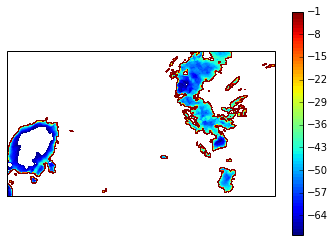

In [1061]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon1, lat1, d1,levels=np.arange(-70,0,1), transform=ccrs.PlateCarree())
cbar=plt.colorbar()

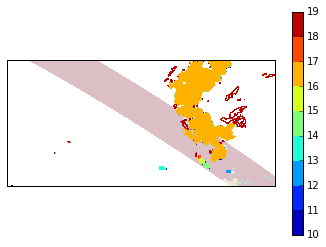

In [1062]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(td['lon'], td['lat'], td['p'], levels=np.arange(0,10,1), transform=ccrs.PlateCarree(), cmap='Pastel1')
plt.contourf(lon1, lat1, labels, levels=np.arange(10,20,1), transform=ccrs.PlateCarree())
#plt.contour(td['lon'], td['lat'], td['p'], levels=np.arange(0,10,1), transform=ccrs.PlateCarree())
ax.coastlines()
cbar=plt.colorbar()

In [1063]:
inds=np.where(labels==17)
print(len(inds[0]))
# cut a box for every single blob from msg - get min max lat lon of the blob
latmax, latmin = lat1[inds].max() , lat1[inds].min()
lonmax, lonmin = lon1[inds].max() , lon1[inds].min()
td = t.getDData(date.year, date.month, date.day, date.hour, date.minute, cut=[latmin-0.3, latmax+0.3])

dt0=dm[ind] 
ndate = date + dt.timedelta(minutes=int(dt0) )                
print('Date1', ndate)                              
ml0=m.getData(y=ndate.year, m=ndate.month, d=ndate.day, h=ndate.hour, mi=ndate.minute, llbox=[lonmin-0.5, lonmax+0.5, latmin-0.5, latmax+0.5]) 

15223
Date1 2009-09-02 00:15:00


In [1064]:
x, y = pyproj.transform(salem.wgs84, proj, ml0['lon'], ml0['lat'])
xmax, xmin = np.max(x), np.min(x)
ymax, ymin = np.max(y), np.min(y)
dx = 5000
nx, r = divmod(xmax - xmin, dx)
ny, r = divmod(ymax - ymin, dx)
grid = salem.Grid(nxny=(nx, ny), dxdy=(dx, dx), ll_corner=(xmin, ymin), proj=proj)            
xi, yi = grid.ij_coordinates
lon, lat = grid.ll_coordinates
xm, ym = grid.transform( ml0['lon'].flatten(), ml0['lat'].flatten(), crs=salem.wgs84)
xt, yt = grid.transform(td['lon'].flatten(), td['lat'].flatten(), crs=salem.wgs84)
mpoints = np.array((ym, xm)).T
tpoints = np.array((yt, xt)).T
inter = np.array((np.ravel(yi), np.ravel(xi))).T
 
outm = griddata(mpoints, ml0['t'].flatten(), inter, method='linear')
outm = outm.reshape((grid.ny, grid.nx))
outt = griddata(tpoints, td['p'].flatten(), inter, method='linear')
outt = outt.reshape((grid.ny, grid.nx)) 

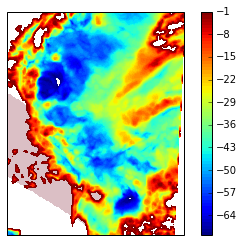

In [1065]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(lon, lat, outt, levels=np.arange(0,10,1), transform=ccrs.PlateCarree(), cmap='Pastel1')
plt.contourf(lon, lat, outm, levels=np.arange(-70,0,1), transform=ccrs.PlateCarree())
#plt.contour(td['lon'], td['lat'], td['p'], levels=np.arange(0,10,1), transform=ccrs.PlateCarree())
ax.coastlines()
cbar=plt.colorbar()

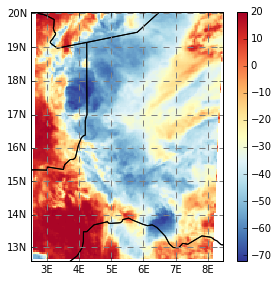

In [1066]:
# cleo map
cm = cleo.Map(grid)
cm.set_cmap(plt.cm.RdYlBu_r)
cm.set_nlevels(256)
cm.set_data(outm)
cm.visualize()

In [1067]:
outl = np.full_like(outm, -150)

xl, yl = grid.transform(lon1[inds], lat1[inds], crs=salem.wgs84, nearest=True, maskout=True)

In [1068]:
outl[yl.compressed(), xl.compressed()]=outm[yl.compressed(), xl.compressed()]

In [1069]:
# zero lag
outt=outt[1:-1, 4:-4]
outl=outl[1:-1, 4:-4]
llon = lon[1:-1, 4:-4]
llat = lat[1:-1, 4:-4]
tmask=np.isnan(outt)
outt[np.isnan(outt)]=-10**-5
outl[np.isnan(outl)]=-150  



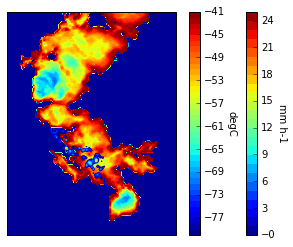

In [1070]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(llon, llat, outt,levels=np.arange(-10**-5,25,1), transform=ccrs.PlateCarree())
cbar=plt.colorbar()
cbar.set_label('mm h-1', rotation=270, labelpad=+11)
plt.contourf(llon, llat ,outl,levels=np.arange(-80,-40,1), transform=ccrs.PlateCarree(), cmap='jet')
cbar=plt.colorbar()
cbar.set_label('degC', rotation=270, labelpad=+11)
plt.contour(llon, llat, outt,levels=np.arange(5,25,1), transform=ccrs.PlateCarree())


#plt.contour(llon, llat, outt,levels=np.arange(100,110,1), transform=ccrs.PlateCarree())
#plt.title('Precip on T original')
#plt.savefig('/users/global/cornkle/grpm/TP_original2.png', dpi=300)
#ax.coastlines()

-42.0


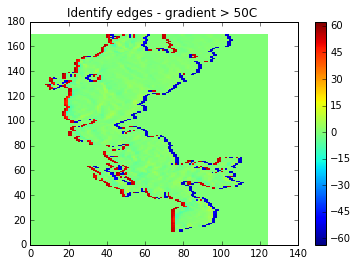

In [1071]:
grad=np.gradient(outl)
plt.pcolormesh(grad[1])
plt.colorbar()
plt.title('Identify edges - gradient > 50C ')
nok = np.where(abs(grad[1]) > 40)
mmeans=np.percentile(d1[inds], 90)
#plt.savefig('/users/global/cornkle/grpm/gradient.png', dpi=300)
print(mmeans)

In [1072]:
o=outl.copy()
o2=outl.copy()
o[o<-100]=mmeans
o2[o2<-100]=mmeans
d=2
i=nok[0]
j=nok[1]

In [1073]:
for ii,jj in zip(i,j):
    
    kernel=o2[ii-d:ii+d+1, jj-d:jj+d+1]
    if not kernel.any():
        o2[ii,jj]=mmeans
    else:    
        o2[ii-d:ii+d+1, jj-d:jj+d+1]=ndimage.gaussian_filter(kernel, 3)

-42.0


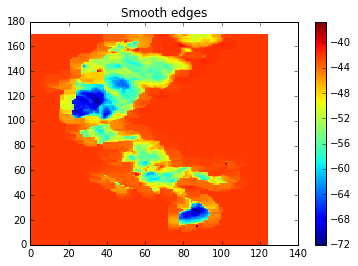

In [1074]:
plt.pcolormesh(o2)
plt.colorbar()
plt.title('Smooth edges')
#plt.savefig('/users/global/cornkle/grpm/smooth.png', dpi=300)
print(mmeans)

27.0


array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  5.82771992e-02,   5.52663215e-07,   5.52663215e-07, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.82771236e-02,   5.52663215e-07,   5.52663215e-07, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  5.82770113e-02,   5.52663215e-07,   5.52663215e-07, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

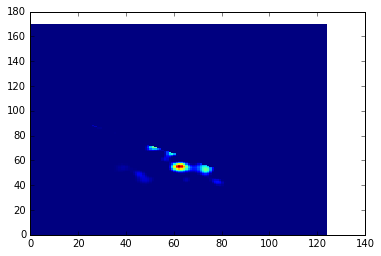

In [1077]:
pos=10
dic = util.waveletTP(o2, outt, 5)
print(dic['scales'][pos])
tt=dic['t'][pos,:,:]
pp=dic['p'][pos,:, :]
tt[tmask]=0
plt.pcolormesh(tt)
tt[0:100]

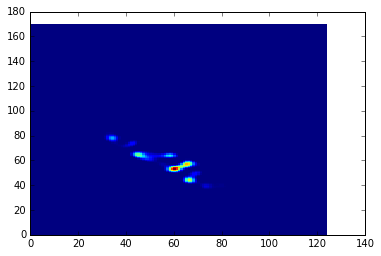

In [1078]:
plt.pcolormesh(pp)

(170, 124)


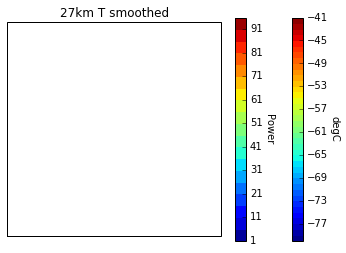

In [1079]:
ax = plt.axes(projection=ccrs.PlateCarree())
plt.contourf(llon, llat ,outl,levels=np.arange(-80,-40,1), transform=ccrs.PlateCarree(), cmap='jet')
cbar=plt.colorbar()
cbar.set_label('degC', rotation=270, labelpad=+11)
plt.contourf(llon, llat ,tt,levels=np.arange(1,100,5), transform=ccrs.PlateCarree(), cmap='jet')
cbar=plt.colorbar()
cbar.set_label('Power', rotation=270, labelpad=+11)
ax.coastlines()
plt.title('27km T smoothed')
#plt.savefig('/users/global/cornkle/grpm/smoothed_ex2.png', dpi=300)
print(llon.shape)

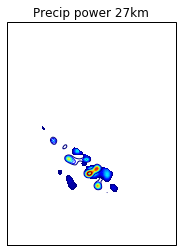

In [1080]:
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.contourf(llon, llat ,outt,levels=np.arange(0,10,1), transform=ccrs.PlateCarree(), cmap='Set1')
#cbar=plt.colorbar()
#cbar.set_label('mm h-1', rotation=270, labelpad=+11)
plt.contourf(llon, llat, tt,levels=np.arange(1,50,1), transform=ccrs.PlateCarree(), cmap='jet')
#cbar=plt.colorbar()
#cbar.set_label('Power', rotation=270, labelpad=+11)
plt.contour(llon, llat, pp,levels=np.arange(1,10,1), transform=ccrs.PlateCarree(), cmap='jet')
plt.title('Precip power 27km')
#plt.savefig('/users/global/cornkle/grpm/P_power27km.png', dpi=300)
ax.coastlines()

In [1087]:
pp.shape

(170, 124)

In [1083]:
thing=match_template(tt, pp[5:-5, 5:-5])
print(max(thing.flatten()))
y,x = np.unravel_index(np.argmax(thing), thing.shape)

0.575787


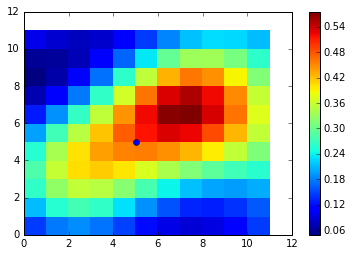

In [1085]:
plt.pcolormesh(thing)
plt.colorbar()
plt.plot(5,5, 'bo')